In [3]:
from bertopic import BERTopic
import json
import pandas as pd
import csv
import pandas as pd
from bertopic.representation import KeyBERTInspired

In [46]:
data = pd.read_csv('../data/depression_anxiety_cleaned.csv')
data['dep_text'] = data['dep_text'].apply(lambda x: ''.join([c for c in str(x) if not c.isdigit()]))
# dropping the rows having NaN values
data = data.dropna()
 
# To reset the indices
data = data.reset_index(drop=True)
 


In [47]:
# Specify the file path where you want to save the CSV file
file_path = 'bert_topic_df.csv'

# Save the DataFrame to a CSV file
data.to_csv(file_path, index=False)

In [48]:
data

,participant_id,dep_all_words,wor_all_words,dep_all_phrases,wor_all_phrases,dep_text,wor_text,Gender,age,PHQtot,GADtot,miniGAD_diagnose,minidep_diagnose,unique_id
0,57dd186e6598aa0001992616,motivated learning passionate enthusiastic happy,motivated enthusiastic learning exercise nutri...,happy eager to learn restful sleep motivated j...,content improving learning motivated better th...,"Over the past two weeks, I have not been depre...","Over the last two weeks, I have not been worri...",1.0,33.0,0.0,1.0,0,0,1
1,586c4a8be9cb31000195ea04,connected engaged alive alert strong,painful repetitive all-consuming random invasive,Feel connected to the world Care about people ...,bogged down by thoughts triggered by thoughts ...,I don't think I have felt depressed. I'm not f...,Yes I have been worried. I have worried about ...,0.0,70.0,17.0,15.0,0,0,2
2,58bf2cf0d294c100010181fa,Yes Somewhat Very Extremely Partially,Yes Mostly Often Constantly Frequently,Mostly Often Constantly Habitually More often ...,Frequently Often Usually Mostly Constantly,I have been depressed because I am worried abo...,I have been very worried for the reasons above...,0.0,63.0,21.0,16.0,0,0,3
3,58d3d69a47aa1e00010476f4,minor unwilling unwanting depressive unbothered,magorly confused scared unknowing unnessery,lonelyness builds from deep within mild depres...,minor manageable unsure scared worried,Over the past weeks i have been feeling depre...,I have been worried many times in the past 2 w...,0.0,34.0,13.0,13.0,0,0,4
4,5932f5d4991e160001effbd2,family work money bills stressed,tense sad unhappy alone worried,alone sad not myself short fused shouting,stressed alone pressure tired not sleeping well,yes very much just seem everything is getting ...,I have found work very stressful and i am only...,1.0,50.0,9.0,12.0,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,5f2a9a35a696ad2e039af96a,Worried Fear Motivation Change Tired,Fear Alone Sad Overthinking Tired,Worried Not wanting to go out Finding hard to ...,Anxiety Fear Change Panic On edge,There has been time when I have not wanted to ...,I have felt allot of worry and anxiety as I ha...,0.0,31.0,11.0,14.0,0,1,972
946,5f2aad9ef401403198b127b5,Tired Down Sad Unhappy Tearful,Scared Anxious Fearful Frightened Cautious,Fed up Bored Lazy Sadness Worry,Scared Anxious Constant worrying Sleepy Over t...,"I’m not sure if I’ve been depressed exactly, I...",Yes I have been extremely worried. One because...,0.0,28.0,20.0,20.0,1,1,973
947,5f2abac3ee0e8335d5ff36b7,Unsettled Lazy Drowsy Overwhelmed Nervous,Panic Unhappy Stressed Nervous Anxious,Unhappy Drowsy Lazy Mood swings Negative,Panic Worry Overthinking Overwhelmed Unsettled,"I haven’t felt depressed. However, I have expe...",I have been worried about the state of the eco...,0.0,49.0,20.0,13.0,1,1,974
948,5f2b621130ca045b940f4b37,Despair Numbness Guilty Hollow Grief,Overwhelmed Panic Helplessness Uncertainty Sen...,Deep despair Suicidal thoughts Guilt for being...,Overwhelmed very easily Panic Uncertainty abou...,I have suffered from depression since my early...,"I have suffered with anxiety, panic and worry ...",0.0,28.0,22.0,17.0,1,1,975


## Pre-calculate Embeddings

In [49]:
from sentence_transformers import SentenceTransformer
from flair.embeddings import TransformerDocumentEmbeddings

roberta = TransformerDocumentEmbeddings('roberta-base')
#topic_model = BERTopic(embedding_model=roberta)

# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(data["dep_text"], show_progress_bar=True)


Batches: 100%|██████████| 30/30 [00:04<00:00,  6.41it/s]


## Preventing Stochastic Behavior

In [50]:
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

## Controlling Number of Topics

In [51]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)


## Improving Default Representation

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 3))

## Additional Representations

In [53]:
#import openai
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech

from transformers import pipeline
from bertopic.representation import TextGeneration

summarization_prompt = """
I have a topic that is described by the following keywords: [KEYWORDS]
In this topic, the following documents are a small but representative subset of all documents in the topic:
[DOCUMENTS]

Based on the information above, please give a description of this topic in the following format:
description: <description>
"""
# Create your representation model
generator_pipeline = pipeline('text2text-generation', model='google/flan-t5-base')
generator = TextGeneration(generator_pipeline, prompt=summarization_prompt)

# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
#pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

'''
# GPT-3.5
openai.api_key = "sk-..."
prompt = """
I have a topic that contains the following documents: 
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
openai_model = OpenAI(model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)
'''
# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    # "OpenAI": openai_model,  # Uncomment if you will use OpenAI
    "MMR": mmr_model,
    #"POS": pos_model
    #"Generator": generator
}


## Train

In [54]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(data["dep_text"], embeddings=embeddings)

# Show topics
topic_model.get_topic_info()

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame({"topic": topics, "document": data["dep_all_phrases"]})
df

,topic,document
0,3,happy eager to learn restful sleep motivated j...
1,-1,Feel connected to the world Care about people ...
2,0,Mostly Often Constantly Habitually More often ...
3,15,lonelyness builds from deep within mild depres...
4,22,alone sad not myself short fused shouting
...,...,...
942,26,Worried Not wanting to go out Finding hard to ...
943,0,Fed up Bored Lazy Sadness Worry
944,-1,Unhappy Drowsy Lazy Mood swings Negative
945,4,Deep despair Suicidal thoughts Guilt for being...


In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_documents(docs=data["dep_text"],hide_annotations=True)

In [ ]:
topics_per_class = topic_model.topics_per_class(data["dep_text"], classes=data["PHQtot"])


28it [00:00, 122.11it/s]


In [ ]:
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=20)


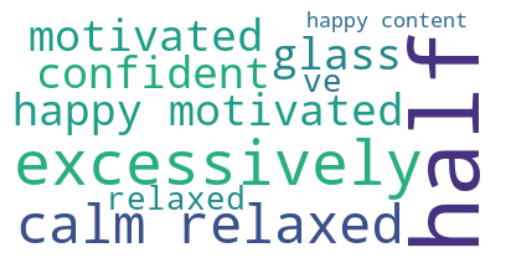

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=2)

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(data["dep_all_phrases"])

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:00<00:00, 532.24it/s]


In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)


In [ ]:
topic_distr, _ = topic_model.approximate_distribution(data["dep_all_ph"])

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 21.92it/s]


In [ ]:
topic_model.visualize_distribution(topic_distr[2])

In [ ]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(data["dep_text"], calculate_tokens=True)

# Visualize the token-level distributions
#df = topic_model.visualize_approximate_distribution(data["dep_all_phrases"][1], topic_token_distr[1])
#df


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


In [ ]:
import numpy as np
topic_distr.shape

(950, 36)

In [ ]:
columns = ["t_" + str(i) for i in range(topic_distr.shape[1])]
with open("topic_distr_dep_text.csv", 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(columns)
    # Write the array to the CSV file
    csv_writer.writerows(topic_distr)

In [ ]:
topic_model.topic_aspects_

{'KeyBERT': {-1: [('feel depressed', 0.9935657),
   ('felt depressed', 0.9935493),
   ('say depressed', 0.9934275),
   ('mental health', 0.9932722),
   ('depressed', 0.99314004),
   ('worse', 0.9931363),
   ('low', 0.9931361),
   ('medication', 0.99313253),
   ('health', 0.9931291),
   ('depression', 0.993127)],
  0: [('feeling tired', 0.9948879),
   ('low', 0.99484396),
   ('health', 0.9948227),
   ('difficult', 0.9948182),
   ('depressed', 0.9948134),
   ('negatively', 0.9948128),
   ('lot', 0.99481267),
   ('right', 0.99481106),
   ('various', 0.9948109),
   ('situation', 0.9948106)],
  1: [('feeling depressed', 0.99609405),
   ('feel depressed', 0.99607575),
   ('felt depressed', 0.9960616),
   ('felt motivated', 0.9960461),
   ('period', 0.9959576),
   ('depressed', 0.99593645),
   ('ve', 0.9959341),
   ('think depressed', 0.99593085),
   ('lots', 0.9959297),
   ('positive', 0.995929)],
  2: [('haven depressed couple', 0.9962683),
   ('ve', 0.99623334),
   ('lead', 0.9962321),
   

In [ ]:
topic_model.get_document_info(data["dep_all_phrases"])

,Document,Topic,Name,Representation,KeyBERT,MMR,Generator,Representative_Docs,Top_n_words,Probability,Representative_document
0,happy eager to learn restful sleep motivated j...,31,31_deep_tired exhausted_happy_happy stressed,"[deep, tired exhausted, happy, happy stressed,...","[happy tired, tired exhausted, walking, motiva...","[deep, tired exhausted, happy, happy stressed,...","[Tired happy deep sleep walking football, , , ...","[Happy Tired Exhausted Feel well Normal, Enthu...",deep - tired exhausted - happy - happy stresse...,1.000000,False
1,Feel connected to the world Care about people ...,-1,-1_tired_feeling_lonely_sad,"[tired, feeling, lonely, sad, low, worried, an...","[lack motivation, calm, numb, stress, negative...","[tired, feeling, lonely, sad, low, worried, an...","[i feel low and lonely, , , , , , , , , ]",[Uninterested in hobbies Unmotivated at work S...,tired - feeling - lonely - sad - low - worried...,0.000000,False
2,Mostly Often Constantly Habitually More often ...,26,26_yes_occasionally_frequently_constantly,"[yes, occasionally, frequently, constantly, ha...","[didn, worrying, absolutely, hide, constantly,...","[yes, occasionally, frequently, constantly, ha...","[Sometimes it’s hard sometimes, sometimes, fre...",[occasionally During certain periods At times ...,yes - occasionally - frequently - constantly -...,1.000000,False
3,lonelyness builds from deep within mild depres...,18,18_felt_cried_feel_activities,"[felt, cried, feel, activities, sad felt, isol...","[feeling lonely, felt sad felt, feel sad, felt...","[felt, cried, feel, activities, sad felt, isol...",[I have cried a lot I have felt isolated I fel...,[Yes felt down Felt isolated Felt unwell Tired...,felt - cried - feel - activities - sad felt - ...,0.908044,False
4,alone sad not myself short fused shouting,-1,-1_tired_feeling_lonely_sad,"[tired, feeling, lonely, sad, low, worried, an...","[lack motivation, calm, numb, stress, negative...","[tired, feeling, lonely, sad, low, worried, an...","[i feel low and lonely, , , , , , , , , ]",[Uninterested in hobbies Unmotivated at work S...,tired - feeling - lonely - sad - low - worried...,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...
945,Worried Not wanting to go out Finding hard to ...,-1,-1_tired_feeling_lonely_sad,"[tired, feeling, lonely, sad, low, worried, an...","[lack motivation, calm, numb, stress, negative...","[tired, feeling, lonely, sad, low, worried, an...","[i feel low and lonely, , , , , , , , , ]",[Uninterested in hobbies Unmotivated at work S...,tired - feeling - lonely - sad - low - worried...,0.000000,False
946,Fed up Bored Lazy Sadness Worry,29,29_weary_lazy_fed_sad lonely,"[weary, lazy, fed, sad lonely, lonely, tired s...","[lonely tired, sad lonely, lonely sad, drained...","[weary, lazy, fed, sad lonely, lonely, tired s...",[Weary lonely lonely tired sluggish tired lone...,"[Fed up Bored Lazy Sadness Worry, Yawn Weary F...",weary - lazy - fed - sad lonely - lonely - tir...,0.942197,True
947,Unhappy Drowsy Lazy Mood swings Negative,20,20_tiredness_headaches_mood_moodiness,"[tiredness, headaches, mood, moodiness, unhapp...","[depression anxiety, low mood, tiredness, slee...","[tiredness, headaches, mood, moodiness, unhapp...","[i have a headache, , , , , , , , , ]",[tiredness fatigue sometimes irritated unhappi...,tiredness - headaches - mood - moodiness - unh...,1.000000,False
948,Deep despair Suicidal thoughts Guilt for being...,6,6_suicidal_suicidal thoughts_self_thoughts,"[suicidal, suicidal thoughts, self, thoughts, ...","[depressed melancholic, feeling uselessness, l...","[suicidal, suicidal thoughts, self, thoughts, ...",[Suicide is the act of committing suicide. Sui...,[No energy Constant crying No motivation to co...,suicidal - suicidal thoughts - self - thoughts...,0.783344,True


In [6]:
import bert_topic
import pandas as pd
data = pd.read_csv('../../data/depression_anxiety_cleaned.csv')
embedding_models = ["distilroberta"] # "miniLM", "mpnet", "multi-mpnet", 
for data_var in ["dep_text"]: #, "dep_all_words", "wor_all_words", "wor_all_phrases", "wor_text", "dep_text", ]:
    for embedding_model in embedding_models:
        topic_model = bert_topic.create_bertopic_model(
            data=data,
            data_var=data_var,
            embedding_model=embedding_model,  # provide a value for embedding_model
            umap_model="default",       # provide a value for umap_model
            hdbscan_model="default",    # provide a value for hdbscan_model
            vectorizer_model="default",  # provide a value for vectorizer_model
            representation_model="default",  # provide a value for representation_model
            top_n_words=10,  # provide a value for top_n_words
            n_gram_range=(1, 3),
            stop_words = "english",  # provide a value for n_gram_range
            save_dir="./results"  # provide a value for save_dir
        )

               participant_id  \
0    57dd186e6598aa0001992616   
1    586c4a8be9cb31000195ea04   
2    58bf2cf0d294c100010181fa   
3    58d3d69a47aa1e00010476f4   
4    5932f5d4991e160001effbd2   
..                        ...   
971  5f2a9a35a696ad2e039af96a   
972  5f2aad9ef401403198b127b5   
973  5f2abac3ee0e8335d5ff36b7   
974  5f2b621130ca045b940f4b37   
975  5f2efc6127d9ef108a1b41bd   

                                        dep_all_words  \
0    motivated learning passionate enthusiastic happy   
1                connected engaged alive alert strong   
2               Yes Somewhat Very Extremely Partially   
3     minor unwilling unwanting depressive unbothered   
4                    family work money bills stressed   
..                                                ...   
971              Worried Fear Motivation Change Tired   
972                    Tired Down Sad Unhappy Tearful   
973         Unsettled Lazy Drowsy Overwhelmed Nervous   
974              Despair Numbness

2023-11-13 11:54:08,660 - BERTopic - Reduced dimensionality
2023-11-13 11:54:08,677 - BERTopic - Clustered reduced embeddings
100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


In [9]:
data = topic_model.topic_representations_

In [14]:
# Filter out the topic with label -1 and start labeling from 1
filtered_data = {label: terms for label, terms in data.items() if label != -1}

# Convert the filtered dictionary to a DataFrame with labeled topics starting from 1
df = pd.DataFrame([(f't_{i}', ', '.join([term for term, _ in terms])) for i, (_, terms) in enumerate(filtered_data.items(), start=1)], columns=['topic', 'top_terms'])

In [15]:
df

,Topic,Top Terms
0,t_1,"depressed past weeks, weeks depressed, depress..."
1,t_2,"yes depressed, yes depressed weeks, yes depres..."
2,t_3,"haven felt depressed, haven depressed, depress..."
3,t_4,"depressed past weeks, depressed weeks, depress..."
4,t_5,"feeling depressed, feel sad depressed, sadness..."
5,t_6,"feeling depressed, extremely depressed, depres..."
6,t_7,"depressed weeks, weeks depressed, depression, ..."
7,t_8,"depressed lockdown, feel depressed, depression..."
8,t_9,"low anxious, mood fluctuating, low mood days, ..."
9,t_10,"depression anxiety, depression feeling, depres..."


In [4]:
topic_model = BERTopic.load("./results/dep_text/distilroberta/my_model")
topic_model.visualize_topics()

In [5]:
topic_model.visualize_barchart(top_n_topics=30)

In [96]:
topic_model.visualize_hierarchy()

In [6]:
topic_dict = topic_model.topic_representations_
len(topic_dict)

31

In [8]:
# Specify the directory to save CSV files
csv_dir = './topic_csv_files/'

# Iterate over topics and create CSV files
for topic, topic_data in topic_dict.items():
    # Create a CSV file for each topic
    topic = int(topic)+1
    print(topic)
    csv_file_path = f'{csv_dir}{topic}_top_words.csv'

    # Write the topic data to the CSV file
    with open(csv_file_path, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['Word', 'phi'])

        # Write each row individually
        writer.writerows(topic_data)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [99]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(data["dep_all_phrases"], calculate_tokens=True)

  0%|          | 0/1 [00:00<?, ?it/s]


NotFittedError: Vocabulary not fitted or provided

In [78]:
len(topic_token_distr)

950

In [79]:
df = topic_model.visualize_approximate_distribution(data["dep_all_phrases"][:], topic_token_distr[:])

TypeError: expected string or bytes-like object, got 'Series'

In [1]:
topic_model.get_topic_info()

NameError: name 'topic_model' is not defined